# Metropolis-Hasting Algorithm

接受/拒绝采样和重要性采样应用在高维（变量多的）分布上的时候效率比较低。这种情况下可以使用马可夫链蒙特卡洛（Markov Chain Monte Carlo）采样方法，简称 MCMC。


## 什么是马可夫链

马可夫是？马可夫（Andrey Markov）是俄国的一位数学家。他在二十世纪初研究了一类随机过程（现在叫做马可夫随机过程），这种随机过程的特点是：要预判系统下次的可能状态只需知道当前状态，不需要知道历史状态，或者说知道历史状态并不能对预判提供**额外**帮助。

比如，整数随机漫步（Random walk）就属于马可夫随机过程。假设开始的时候你处在数轴的原点（0），然后每隔一秒你往左或者右走一步（一个单位），每一步的方向都是随机选择的，各有 50% 的概率。这样经过了一段时间后，假设你处在 +8 的位置上。这个时候我们知道，你下一个可能的位置是 +7 和 +9，各有 50% 的可能性。而知道你之前究竟是经过 +6、+7 到达 +8 还是经过 +10、+9 到达 +8 并不能对下一个位置的判断提供额外帮助。

那相对应的，如果历史状态能够对预判提供帮助就不是马可夫随机过程。比如（参考 [wiki](https://www.wikiwand.com/en/Markov_chain)），你包里有 5￥、10￥、20￥ 纸币各 4 张，然后每次随机从包里取出一张，取出的现金总额形成一个序列 $X$，$X_0=0$。假如你从中依次取出了全部 4 张 5￥ 和 2 张 20￥ 纸币，现在 $X_6 = 60$。基于这个过程（知道历史状态就能推出过程）你知道 $X_7$ 是一定不会比 70 小的，因为 5￥ 的纸币已经没有了。但是如果你只知道 $X_6=60$，而不清楚之前的过程，那 $X_7$ 小于 70 的可能性还是有的，因为之前的过程可能是 5￥、5￥、10￥，10￥，10￥，20￥（对应状态 5, 10, 20, 30, 40, 60），所以取出 5￥ 的可能性还有。这就是说历史状态对下次可能状态的预判提供了额外的信息。所以这个序列 $X$ 是非马可夫随机过程。

实际的马可夫随机过程例子还包括布朗运动（微小颗粒的无规则运动）等等。由于系统下次状态的判断只跟当前状态有关，用节点表示某一时刻的状态，用连线表示依赖关系，这类系统的状态转换（运动）可以表示下图：

<img src="markov-chain.png">
，如链状，所以叫马可夫链。

但是研究这种随机过程有什么用呢？

因为存在随机性，要准确预判系统在某一时刻的状态是不可能的，但是系统未来的状态在统计意义上的特性却可以预判到。事实是，当这类过程满足一些条件的时候，随机过程将达到（收敛到）一个稳定的分布，即每个可能状态出现的概率不再改变。

有了这个性质，我们就可以设计马可夫链，以保证它会收敛到目标分布，然后再模拟（运行）这个随机过程。在模拟的过程中产生的样本自然就符合目标分布。

一般定义这类过程时主要包括（离散情况下），状态空间 $S$，状态转换概率 $p_{ij}$，表示从状态 $i$ 转换到 $j$ 的概率，并且有：

$$
\sum_{j}p_{ij} = 1\\
\sum_{i}p_{ij} = 1
$$
，表示状态 $i$ 转换到所有其他状态的概率之和是 1，并且其他所有状态转换到状态 $i$ 的概率之和也是 1.

对应到上面的整数随机漫步，$S$ 是所有整数，$p_{ij}$ 是当前位置的左右两个整数概率各位 0.5，其余整数概率为 0。

### 如何保证收敛

在设计马可夫链之前需要先知道，符合什么样的条件可以保证这个随机过程会收敛到稳定分布。

稳定分布是指，存在一个向量 $\pi$，其中的元素代表各个状态的概率，且满足：

\begin{align}
0 \leq \pi_{i} \leq 1\\
\sum_{i \in S}\pi_{i} = 1\\
\pi_{i} = \sum_{j \in S}\pi_{j}p_{ji}
\end{align}
.  其中 $p_{ji}$ 即上面提到的，从状态 $j$ 转换到状态 $i$ 的概率。

上面的条件说明这个随机过程趋于稳定：各个状态出现的概率是确定的，每一次的状态转换并不会改变各个状态总体的概率，即 $\pi$.

那如何设计转换过程（$p_{ij}$）才能满足上面的条件呢？一个方法是保证 $\pi_{i}p_{ij}=\pi_{j}p_{ji}$. 因为：

$$
\sum_{j}\pi_{j}p_{ji} = \sum_{j}\pi_{i}p_{ij} = \pi_{i}\sum_{j}p_{ij} = \pi_{i}
$$
，满足上面稳定分布的条件（注意第二步的替换，第三步与 $j$ 无关的 $\pi$ 的提取，第四步用到转换概率的和为 1）。

这个 $\pi_{i}p_{ij}=\pi_{j}p_{ji}$ 的方法叫 **detailed balance**，它强调了每一对（detailed）状态转换之间的对称性：意思是说系统处于状态 $i$ 并且下次转换到了 $j$ 的概率与系统处于状态 $j$ 并且下次转换到了 $i$ 的概率相等。这是一个比较严格的要求，可以保证收敛到稳定分布，是个充分条件（但不是必要条件），后面的马可夫链的设计也是基于这个条件。

另外一个要提到的问题是，系统可能会有不止一个稳定分布，而我们希望无论系统的初始状态是什么，最后都能收敛到同一个稳定分布。这个要求可以通过附加两个条件来满足，即：(1) 系统的每个状态都可以在有限的时间（步数）内被重新访问到（或者在任意足够大的有限的时间范围内，系统的所有状态都能被访问到）；(2) 没有某个状态会以**固定**的间隔被访问到。简单的理解是说系统内的状态不能存在孤岛和半岛，并且状态转换完全随机。有了这两个条件，系统最终收敛到的唯一的稳定分布叫做均衡分布。

## 什么是蒙特卡洛方法

蒙特卡洛（Monte Carlo）是摩纳哥的一个赌场。蒙特卡洛方法是指使用随机模拟的方法解决一些其它方法（比如数学分析）难以解决的问题。这个方法存在很久了，但是这个叫法始于美国曼哈顿计划（原子弹项目），其中他们使用随机模拟的办法研究中子扩散问题（不懂，具体可以参考 [wiki](https://www.wikiwand.com/en/Monte_Carlo_method)）。

而一个直观的例子是，使用随机点数的方法近似求得 $\pi$。

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Pi_30K.gif/440px-Pi_30K.gif">

（图来自 wiki）

上面正方形边长和园的半径是 1，正方形的面积是 1，1/4 圆的面积是 $\frac{\pi}{4}$，面积之比是 $\frac{\pi}{4}$。我们均匀的在正方形中随机撒一些点，然后数一下距离圆心距离小于 1 的点，这个数目和点的总数之比就是 $\frac{\pi}{4}$ 的近似值。所以 $\pi$ 近似等于点数之比乘以 4。可以看到，随机的点数越多，这个近似值越精确。

蒙特卡洛方法的应用还有很多，以后慢慢研究。而这篇介绍的采样方法正是使用随机模拟的方式去逼近目标分布。

## Meropolis-Hasting 算法

上面提到，使用 MCMC 方法对目标分布采样的主要工作是设计一个状态转换过程 $p_{ij}$，使得 **detailed balance** 条件得到满足：$\pi_{i}p_{ij} = \pi_{j}p_{ji}$，$\pi$ 是目标分布。

Metropolis-Hasting 算法的方案是：使用一个已知的条件分布 $q(x^{*} \mid x)$ 作为提议分布（proposal distribution），然后新样本的接受概率为

$$
A(x^{*}, x^{(t)}) = min(1, \frac{\widetilde{\pi}(x^{*})q(x^{(t)} \mid x^{*})}{\widetilde{\pi}(x^{(t)})q(x^{*} \mid x^{(t)})})
$$
，其中 $\widetilde{\pi}$ 是概率 $\pi$ 的未归一化（unnormalized）版本：$\pi(x) = \frac{\widetilde{\pi}(x)}{Z_{\pi}}$。

下面看一下，这个方案如何满足 **detailed balance** 条件：

\begin{align}
\pi(x)q(x^{*} \mid x)A(x^{*}, x) & = min(\pi(x)q(x^{*} \mid x), \pi(x^{*})q(x \mid x^{*}))\\
                                 & = min(\pi(x^{*})q(x \mid x^{*}), \pi(x)q(x^{*} \mid x))\\
                                 & = \pi(x^{*})q(x \mid x^{*})A(x, x^{*})
\end{align}
（第一步是带入 A，第二步是交换位置，第三步是提取出 A）。

转换概率 $p_{ij}$ 可以认为是：$q(x_j \mid x_i)A(x_j, x_i) = min(q(x_j \mid x_i), q(x_i \mid x_j)\frac{\pi_{j}}{\pi_{i}})$.

下面验证一下从状态 $i$ 转换到所有状态的概率之和是否等于 1：$\sum_{j}q(x_j \mid x_i)A(x_j, x_i) = \sum_{j}min(q(x_j \mid x_i), q(x_i \mid x_j)\frac{\pi_{j}}{\pi_{i}})$。先假设 $q$ 是对称的，即 $q(x^{'} \mid x) = q(x \mid x^{'})$，则上面的等式等于 $\sum_{j}q(x_j \mid x_i)min(1, \frac{\pi_{j}}{\pi_{i}})$。由于 $\sum_{j}q(x_j \mid x_i) = 1$ 而 $min(1, \frac{\pi_{j}}{\pi_{i}}) \leq 1$，所以 $\sum_{j}q(x_j \mid x_i)A(x_j, x_i) \leq 1$，就是说转换到所有状态的概率之和并不一定等于 1。

上面的问题是因为 Meropolis-Hasting 算法中有一步没有提到，即如果新提议的 $x^{*}$ 没有被接受，则前一步的 $x$ 会被拷贝一份保留下来。所以：

\begin{align}
p_{ii} & = q(x_i \mid x_i) + \sum_{j \neq i}q(x_j \mid q_i)(1 - min(1, \frac{\pi_{j}}{\pi_{i}})) \\
       & = q(x_i \mid x_i) + \sum_{j \neq i}q(x_j \mid q_i)max(0, 1 - \frac{\pi_j}{\pi_i})
\end{align}.

有了上面等式中的弥补项 $\sum_{j \neq i}{\cdots}$，可以保证转换到所有状态的概率之和 $\sum_{j}p_{ij}$ 为 1。

所以这个算法的步骤是：

* 初始化
  1. 选择一个初始样本 $x_0$
  1. 设置 t = 0
* 循环
  1. 随机从条件概率 $q(x^{*} \mid x^{(t)})$ 中采样出新样本 $x^{*}$
  1. 计算新样本的接受概率 $A(x^{*}, x^{(t)}) = min(1, \frac{\widetilde{\pi}(x^{*})q(x^{(t)} \mid x^{*})}{\widetilde{\pi}(x^{(t)})q(x^{*} \mid x^{(t)})})$
  1. 接受或者拒绝
    1. 从 $[0, 1]$ 均匀采样出 $u$
    1. 如果 $u \leq A(x^{*}, x^{(t)})$，保留 $x^{*}$，设置 $x^{(t+1)} = x^{*}$
    1. 如果 $u > A(x^{*}, x^{(t)})$，设置 $x^{(t+1)} = x^{(t)}$ （拷贝 $x^{(t)}$）
  1. 设置 $t = t + 1$

## 例子

下面看一下效果。

目标分布是前面 [Importance Sampling](importance_sampling.html) 中用到的高斯混合分布，提议分布 $q(x^{*} \mid x)$ 是以上个样本为中心、标准方差为 2 的高斯分布。

实际的目标分布：

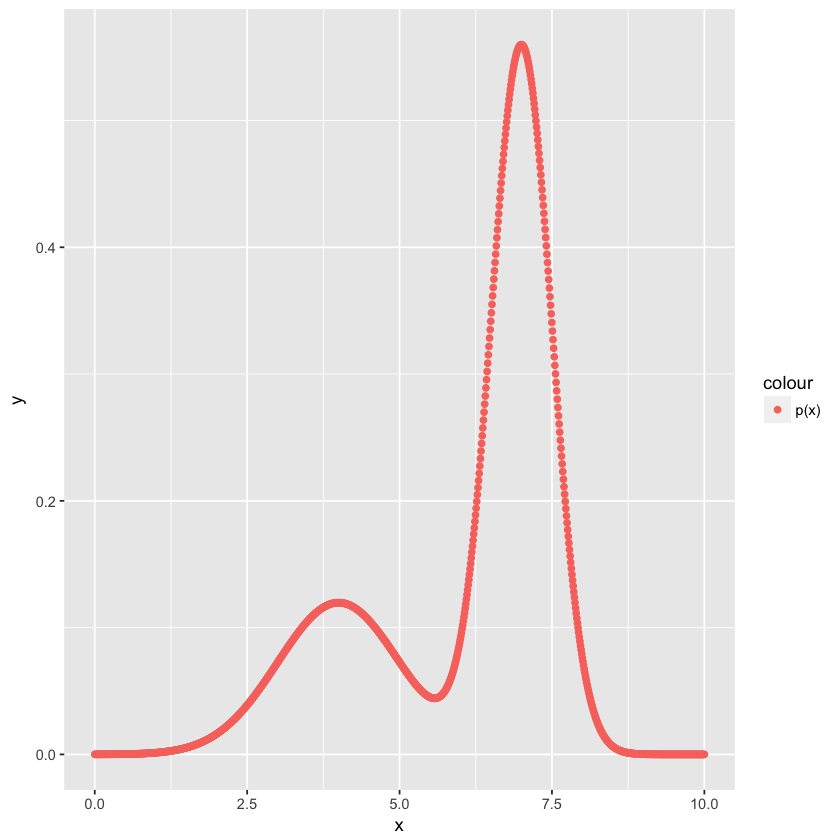

In [3]:
library(ggplot2)
ptilde = function(x) {
    p = 0.3 * dnorm(x, mean=4, sd=1) + 0.7 * dnorm(x, mean=7, sd=0.5)
    return(p)
}
x=seq(0,10,length=1000)
df = data.frame(x=x, y=ptilde(x))
ggplot(df, color=variable)+geom_point(aes(x,y, col='p(x)'))

采样过程：

In [4]:
n = 20000
x0 = 2 # last x
xs = c()
mhq = function(x) {
    return(rnorm(1, mean=x, sd=2))
}
mhdq = function(x1, x2) {
    return(dnorm(x1, mean=x2, sd=2))
}
for (i in seq(0, 1, length=n)) {
    q = mhq(x0)
    A = min(1, (ptilde(q)*mhdq(x0,q))/(ptilde(x0)*mhdq(q, x0)))
    u = runif(1, min=0, max=1)
    if (u <= A) {
        x0 = q
    }
    xs = append(xs, x0)
}

采样数据的直方图：

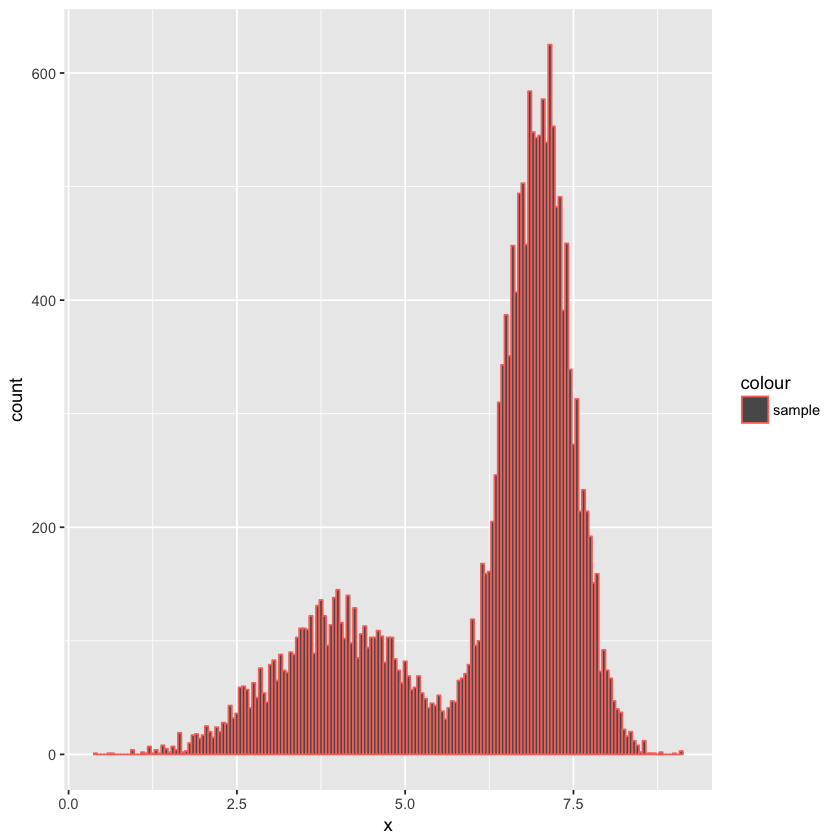

In [5]:
df = data.frame(x=xs)
ggplot(df, color=variable)+geom_histogram(aes(x, col='sample'), binwidth=0.05)

可以看出采样出的样本大致符合目标分布。

由于高斯分布是对称的，所以 $DensityNormal(x^{*}, mean=x) = DensityNormal(x, mean=x^{*})$（标准方差相同），上面采样步骤中的 mhdq 可以省略。

多维度的例子在后面 Gibbs Sampling 方法里一起看。